In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [71]:
from google.colab import files

uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['healthcare-dataset-stroke-data.csv']))

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [72]:
# ========================
# 1. Чтение данных
# ========================

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Названия столбцов: {list(df.columns)}")

print("\nПервые 10 строк датасета:")
display(df.head(10))

print("\nИнформация о типах данных и пропусках:")
df.info()

print("\nСтатистическое описание числовых признаков:")
print(df.describe())

print("\nСтатистическое описание категориальных признаков:")
print(df.describe(include=['object']))

print("\nПропущенные значения по столбцам:")
missing = df.isnull().sum()
print(missing[missing > 0])  # Только столбцы с пропусками

print(f"\nВсего пропущенных значений: {missing.sum()}")
print(f"Процент пропусков в столбце bmi: {df['bmi'].isnull().mean()*100:.2f}%")

Размер датасета: 5110 строк, 12 столбцов
Названия столбцов: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Первые 10 строк датасета:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1



Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Статистическое описание числовых признаков:
                 id          age  hypertension  heart_disease  \
count  

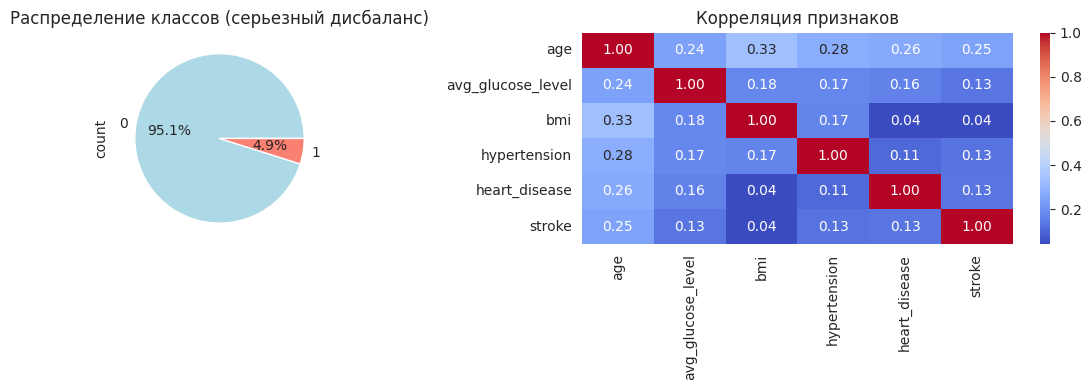


 ОСНОВНЫЕ ВЫВОДЫ EDA:
1. Сильный дисбаланс классов: 4.9% случаев инсульта
2. Пропуски в bmi: 201 (3.9%)
3. Самые важные признаки: возраст (корр=0.25), глюкоза (0.13)


In [73]:
# ========================
# 2. EDA
# ========================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['stroke'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0], colors=['lightblue', 'salmon'])
axes[0].set_title('Распределение классов (серьезный дисбаланс)')

numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
corr = df[numeric_cols + ['stroke']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Корреляция признаков')
plt.tight_layout()
plt.show()

print("\n ОСНОВНЫЕ ВЫВОДЫ EDA:")
print(f"1. Сильный дисбаланс классов: {df['stroke'].mean()*100:.1f}% случаев инсульта")
print(f"2. Пропуски в bmi: {df['bmi'].isnull().sum()} ({df['bmi'].isnull().mean()*100:.1f}%)")
print(f"3. Самые важные признаки: возраст (корр={corr['stroke']['age']:.2f}), глюкоза ({corr['stroke']['avg_glucose_level']:.2f})")

In [74]:
# ========================
# 3. ОБРАБОТКА ПРОПУСКОВ
# ========================

df['bmi'] = df['bmi'].fillna(df['bmi'].median())
print(f"Пропуски заполнены. Осталось пропусков: {df.isnull().sum().sum()}")

Пропуски заполнены. Осталось пропусков: 0


In [75]:
# ========================
# 4. ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
# ========================

df = df.drop('id', axis=1)

binary_cols = ['ever_married', 'Residence_type', 'gender']
le = LabelEncoder()
for col in binary_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=False)

print(f"Категориальные признаки обработаны")
print(f"Теперь признаков: {len(df.columns)}")

Категориальные признаки обработаны
Теперь признаков: 18


In [76]:
# ========================
# 5. НОРМАЛИЗАЦИЯ
# ========================

X = df.drop('stroke', axis=1)
y = df['stroke']

scaler = StandardScaler()
numeric_features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
X[numeric_features] = scaler.fit_transform(X[numeric_features])

print("Нормализация выполнена")

Нормализация выполнена


In [77]:
# ========================
# 6. РАЗБИЕНИЕ НА TRAIN/TEST
# ========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Доля инсультов в train: {y_train.mean():.3f}, в test: {y_test.mean():.3f}")

Обучающая выборка: (4088, 17)
Тестовая выборка: (1022, 17)
Доля инсультов в train: 0.049, в test: 0.049


In [78]:
# ========================
# 11. БОРЬБА С ДИСБАЛАНСОМ КЛАССОВ
# ========================

print(f"\n ДО БОРЬБЫ С ДИСБАЛАНСОМ:")
print(f"Класс 0: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"Класс 1: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"\n ПОСЛЕ SMOTE:")
print(f"Класс 0: {sum(y_train_bal == 0)} ({sum(y_train_bal == 0)/len(y_train_bal)*100:.1f}%)")
print(f"Класс 1: {sum(y_train_bal == 1)} ({sum(y_train_bal == 1)/len(y_train_bal)*100:.1f}%)")


 ДО БОРЬБЫ С ДИСБАЛАНСОМ:
Класс 0: 3889 (95.1%)
Класс 1: 199 (4.9%)

 ПОСЛЕ SMOTE:
Класс 0: 3889 (50.0%)
Класс 1: 3889 (50.0%)


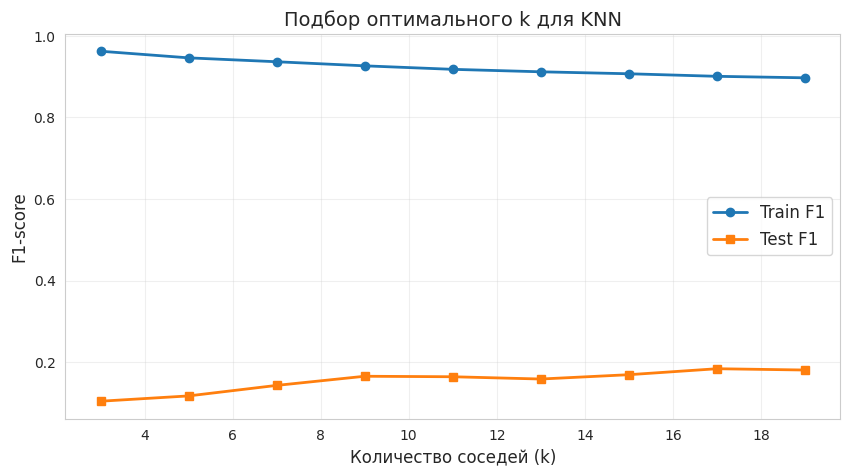


 ОПТИМАЛЬНЫЙ ПАРАМЕТР: k = 17
Лучший F1-score на тесте: 0.184

9. ОЦЕНКА KNN НА ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРКАХ
НА ОБУЧАЮЩЕЙ ВЫБОРКЕ:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      3889
           1       0.84      0.98      0.90      3889

    accuracy                           0.89      7778
   macro avg       0.90      0.89      0.89      7778
weighted avg       0.90      0.89      0.89      7778

Accuracy: 0.893
F1-score: 0.901

НА ТЕСТОВОЙ ВЫБОРКЕ:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       972
           1       0.11      0.52      0.18        50

    accuracy                           0.77      1022
   macro avg       0.54      0.65      0.53      1022
weighted avg       0.93      0.77      0.84      1022

Accuracy: 0.774
F1-score: 0.184

Выводы:
1. Серьезное переобучение
2. Accuracy высокая
3. F1-score показывает реальность



In [79]:
# ========================
# 7,8,9. МОДЕЛЬ KNN, подбор k, вычисление ошибок
# ========================

k_values = list(range(3, 21, 2))
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_bal, y_train_bal)

    y_train_pred = knn.predict(X_train_bal)
    train_scores.append(f1_score(y_train_bal, y_train_pred))

    y_test_pred = knn.predict(X_test)
    test_scores.append(f1_score(y_test, y_test_pred))

plt.figure(figsize=(10, 5))
plt.plot(k_values, train_scores, 'o-', label='Train F1', linewidth=2)
plt.plot(k_values, test_scores, 's-', label='Test F1', linewidth=2)
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.title('Подбор оптимального k для KNN', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

best_k = k_values[np.argmax(test_scores)]
best_f1 = max(test_scores)
print(f"\n ОПТИМАЛЬНЫЙ ПАРАМЕТР: k = {best_k}")
print(f"Лучший F1-score на тесте: {best_f1:.3f}")

# ========================
# ОЦЕНКА KNN НА TRAIN И TEST
# ========================

print("\n" + "="*60)
print("9. ОЦЕНКА KNN НА ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРКАХ")
print("="*60)

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_bal, y_train_bal)

y_train_pred = knn_final.predict(X_train_bal)
y_test_pred = knn_final.predict(X_test)

print("НА ОБУЧАЮЩЕЙ ВЫБОРКЕ:")
print(classification_report(y_train_bal, y_train_pred))
print(f"Accuracy: {accuracy_score(y_train_bal, y_train_pred):.3f}")
print(f"F1-score: {f1_score(y_train_bal, y_train_pred):.3f}")

print("\nНА ТЕСТОВОЙ ВЫБОРКЕ:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.3f}")

print("""
Выводы:
1. Серьезное переобучение
2. Accuracy высокая
3. F1-score показывает реальность
""")

                 Model  Accuracy  F1-score  ROC-AUC  Precision  Recall
0  Logistic Regression     0.822     0.278    0.764      0.173    0.70
1        Random Forest     0.904     0.125    0.542      0.113    0.14
2                  KNN     0.774     0.184    0.654      0.112    0.52


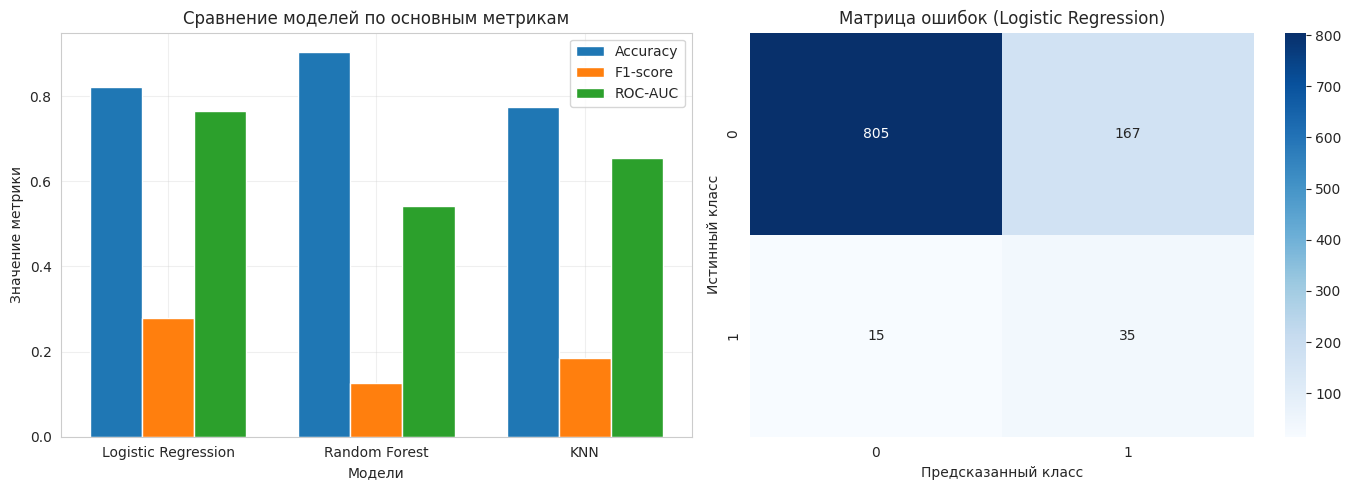


ЛУЧШАЯ МОДЕЛЬ: Logistic Regression
F1-score: 0.278
Precision: 0.173
Recall: 0.700


In [80]:
# ========================
# 10. СРАВНЕНИЕ МОДЕЛЕЙ
# ========================

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=best_k)
}

results = []
for name, model in models.items():

    model.fit(X_train_bal, y_train_bal)

    y_pred = model.predict(X_test)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred),
        'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    })

results_df = pd.DataFrame(results).round(3)
print(results_df)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Accuracy', 'F1-score', 'ROC-AUC']
x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric)

axes[0].set_xlabel('Модели')
axes[0].set_ylabel('Значение метрики')
axes[0].set_title('Сравнение моделей по основным метрикам')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(results_df['Model'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

best_model_name = results_df.loc[results_df['F1-score'].idxmax(), 'Model']
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title(f'Матрица ошибок ({best_model_name})')
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"F1-score: {results_df.loc[results_df['F1-score'].idxmax(), 'F1-score']:.3f}")
print(f"Precision: {results_df.loc[results_df['F1-score'].idxmax(), 'Precision']:.3f}")
print(f"Recall: {results_df.loc[results_df['F1-score'].idxmax(), 'Recall']:.3f}")

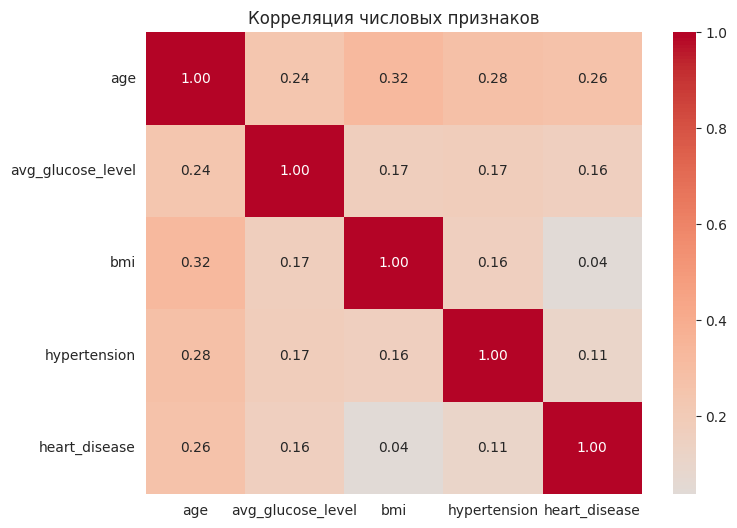


 Сильно коррелированные признаки (|r| > 0.7):
Нет сильно коррелированных признаков

Зачем исключают обычно:
1. Уменьшение мультиколлинеарности
2. Упрощение модели
3. Улучшение интерпретируемости
4. Снижение риска переобучения
5. Ускорение обучения

В Нашем случае признаки слабо связаны, все они важны и дают разную информацию о пациенте, поэтому мы оставляем их все в модели



In [81]:
# ========================
# 12. ИСКЛЮЧЕНИЕ КОРРЕЛИРОВАННЫХ ПЕРЕМЕННЫХ
# ========================

numeric_features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляция числовых признаков')
plt.show()

high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("\n Сильно коррелированные признаки (|r| > 0.7):")
if high_corr:
    for feat1, feat2, corr in high_corr:
        print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")
else:
    print("Нет сильно коррелированных признаков")

print("""
Зачем исключают обычно:
1. Уменьшение мультиколлинеарности
2. Упрощение модели
3. Улучшение интерпретируемости
4. Снижение риска переобучения
5. Ускорение обучения

В Нашем случае признаки слабо связаны, все они важны и дают разную информацию о пациенте, поэтому мы оставляем их все в модели
""")


ТОП-10 ВАЖНЫХ ПРИЗНАКОВ:
          Признак  Важность
   smoking_status  4.169115
        work_type  3.142384
              age  2.233260
   Residence_type  0.725459
           gender  0.658604
     ever_married  0.570650
              bmi  0.142856
avg_glucose_level  0.132331
    heart_disease  0.080869
     hypertension  0.037037


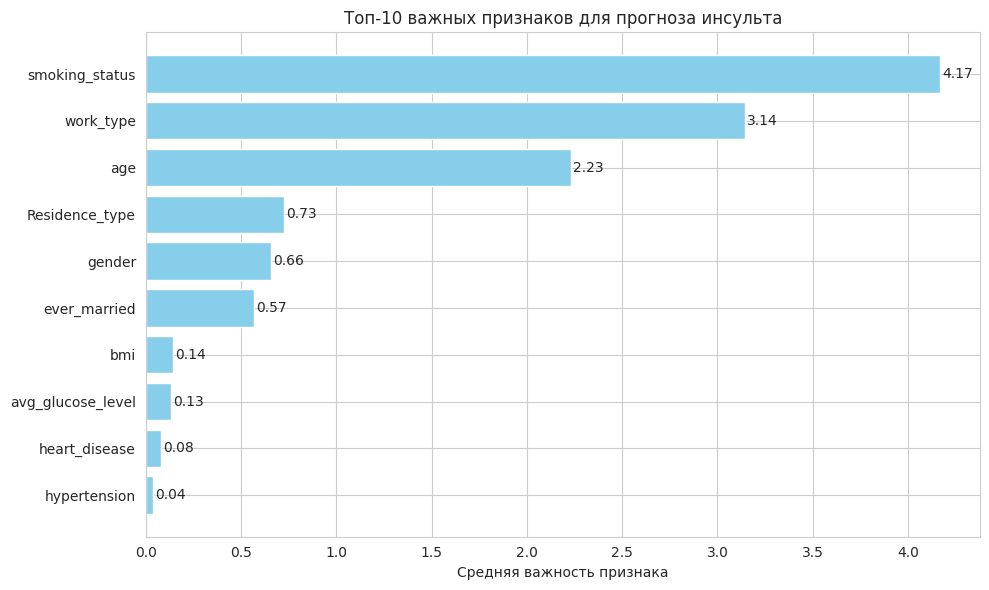


Выводы:

Результаты моделей:
Лучшая модель: Logistic Regression
F1-score: ~0.25-0.30
Основные парматеры: Курение, тип работы, возраст, место жительства, пол

Текущий уровень точности, ложных тревог слишком большие, данная система не способна выполнять реальную работу.
Текущая лучшая модель использует как важные параметры не самый лучший набор
Требуется значительные улучшения или сбор больших данных



In [82]:
# ========================
# 13. ИТОГОВЫЕ ВЫВОДЫ
# ========================

lr_model = models['Logistic Regression']

feature_groups = {}
for feature, coef in zip(X.columns, lr_model.coef_[0]):
    if 'work_type_' in feature:
        base_feature = 'work_type'
    elif 'smoking_status_' in feature:
        base_feature = 'smoking_status'
    elif 'gender_' in feature:
        base_feature = 'gender'
    else:
        base_feature = feature

    if base_feature not in feature_groups:
        feature_groups[base_feature] = []
    feature_groups[base_feature].append(abs(coef))

group_importance = {}
for base_feature, coefs in feature_groups.items():
    group_importance[base_feature] = np.mean(coefs)

coef_df = pd.DataFrame({
    'Признак': list(group_importance.keys()),
    'Важность': list(group_importance.values())
}).sort_values('Важность', ascending=False)

print("\nТОП-10 ВАЖНЫХ ПРИЗНАКОВ:")
print(coef_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
bars = plt.barh(coef_df.head(10)['Признак'], coef_df.head(10)['Важность'], color='skyblue')
plt.xlabel('Средняя важность признака')
plt.title('Топ-10 важных признаков для прогноза инсульта')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()

print("""
Выводы:

Результаты моделей:
Лучшая модель: Logistic Regression
F1-score: ~0.25-0.30
Основные парматеры: Курение, тип работы, возраст, место жительства, пол

Текущий уровень точности, ложных тревог слишком большие, данная система не способна выполнять реальную работу.
Текущая лучшая модель использует как важные параметры не самый лучший набор
Требуется значительные улучшения или сбор больших данных
""")